In [2]:
import scanpy as sc
import graph_tool.all as gt
import schist
import seaborn as sns
import pandas as pd
import anndata
import pickle
import mygene
import scipy.stats
%pylab
%matplotlib inline

/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/SCRNA/lib/python3.8/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [64]:
adata=schist.io.read('../scRNA_paga/state_adata/10XV3_minimize_weighted')

In [83]:
adata=schist.io.read('../scRNA_paga/state_adata/10XV3_minimize')

# Group strenght
Beside the differential gene expression analysis, we tried to use informations coming from cell-affinities also to evaluate the strenght of a group: selecting only cells with high affinity will reduce the total number of cells, however some groups are more stable than others; this should imply that if the clustering algorithm have identified a group but many cells within the group have a low affinity measure, the group could be not significative or less significative than other groups.

In [44]:
adata=adata_w.copy()

Trying to set attribute `.uns` of view, copying.


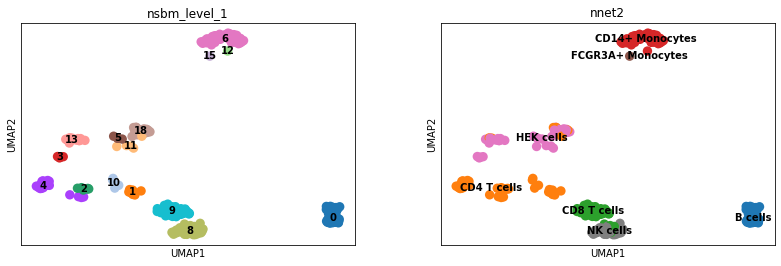

In [41]:
M=adata.uns['nsbm']['cell_affinity']['1']
adata.obs['max_u'] = 1 - np.max(M, axis=1) 
sc.pl.umap(adata[adata.obs.max_u < 1e-100], color=['nsbm_level_1','nnet2'],legend_loc='on data')

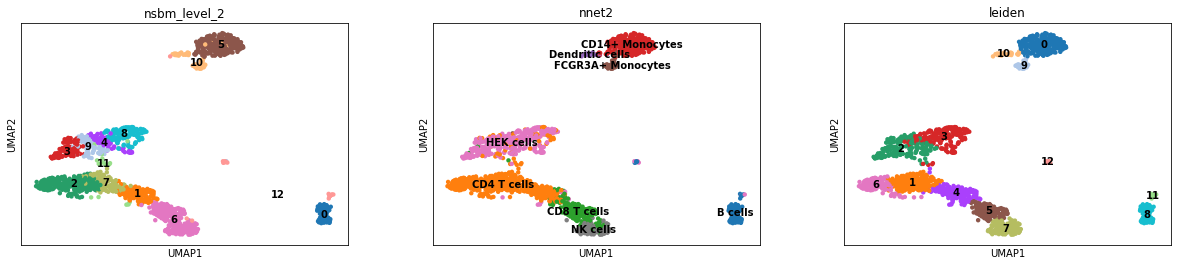

In [28]:
sc.pl.umap(adata, color=['nsbm_level_2','nnet2','leiden'],legend_loc='on data')

### Groups size
One of the first osbervation we made is that increasing the threshold of selection, the size of some groups drops down,while other groups are really stable. Therefore, we reppresented the profile of the size of each group when threshold increases

In [11]:
adata=adata_w

level = '1'
marginals = adata.uns['nsbm']['cell_affinity'][level] 
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
Max = marginals[marginals < 1].max()
Min = marginals[marginals > 0].min()
thr = np.linspace(Min, Max, 10)
thr = np.array([ 10**-x for x in range(0, 11)])

In [12]:
n_cell = adata.obs[f'nsbm_level_{level}'].value_counts().loc[group_names].values
cell_aff = np.max(marginals, axis=1)

D = np.array([adata[cell_aff >  1-t].obs[f'nsbm_level_{level}'].value_counts(sort=False).reindex(group_names, fill_value=0).values for t in thr])

p = D / n_cell
p = p.T

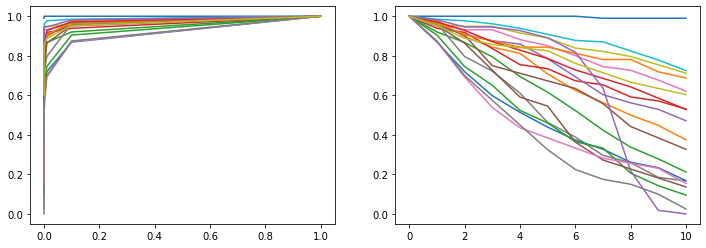

In [13]:
figure(figsize=(12, 4))
subplot(1,2,1)
for x in p:
    plot( thr,x)
subplot(1,2,2)
for x in p:
    plot( x)

The group 0 mantain almost 100% of cells even at the highest threshold, therefore it reppresents a very strogn group. On the other hand, groups as 7,13,15,16 lose the majority of the cells.

The Mutual Information score increases when we use higher threshold both for leiden and nSBM reppresentation, so cell affinity measure has a functional significance.

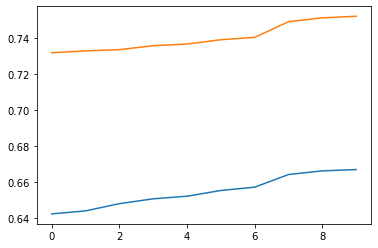

In [42]:
import sklearn
thr = np.array([ 10**-x for x in range(0, 10)])
mi_nsbm=list()
mi_leiden=list()
for i in thr:
    subdata=adata[adata.obs.max_u < i]
    mi_nsbm.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.nsbm_level_1, subdata.obs.nnet2))
    mi_leiden.append(sklearn.metrics.adjusted_mutual_info_score(subdata.obs.leiden, subdata.obs.nnet2))
plot(mi_nsbm)
plot(mi_leiden)

### Uncertainty Areas

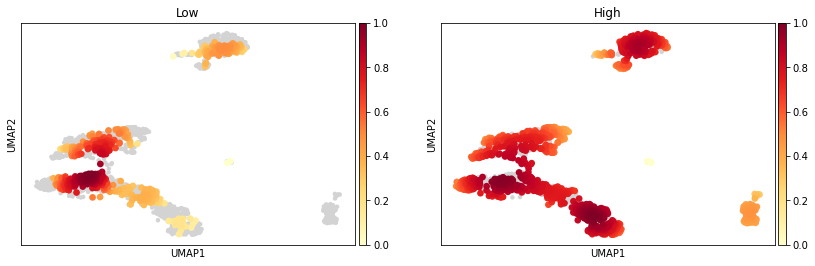

In [35]:
fdata=adata_w
level=str(1)
marginals = fdata.uns['nsbm']['cell_affinity'][level] 
d = pd.Categorical(np.max(marginals, axis=1) > (1 - 1e-5))
d.rename_categories(['Low', 'High'], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

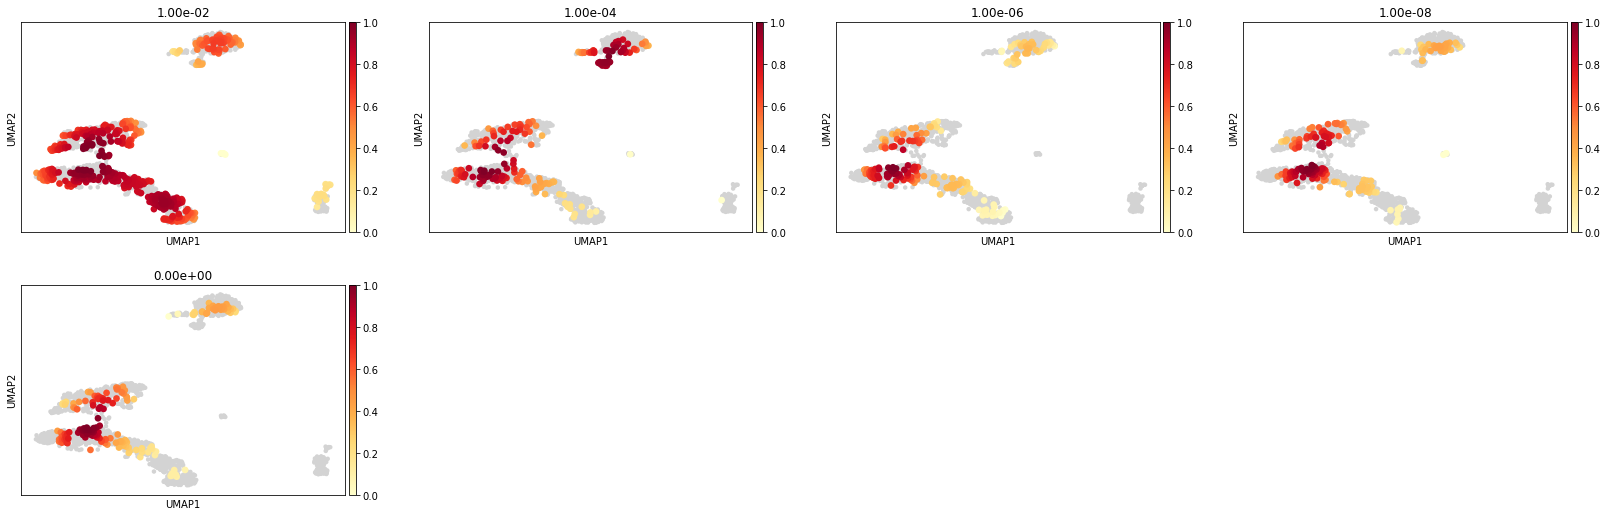

In [34]:
cuts = [0]+ [10**-x for x in range(0, 10, 2)][::-1]
d = pd.Categorical(pd.cut(1-np.max(marginals, axis=1), cuts))
d.rename_categories([f'{x:.2e}' for x in cuts[:-1]][::-1], inplace=True)
fdata.obs['max_A'] = d
sc.tl.embedding_density(fdata, groupby='max_A', key_added='dense_1')
sc.pl.embedding_density(fdata, key='dense_1')

# Reppresentation of strongest groups
The reppresentation of the strongest group is based upon 2 threshold:



1) The first threshold indicates the affinity measure above which we select cells


2) The second threshold indicates how many cells in the same group possess an affinity measure that outmatch the firts threshold

<ipython-input-84-b8faf31145be>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  flat=pd.Series()
/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3256: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


0
1
2
3
5
6
8
9
10
12


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


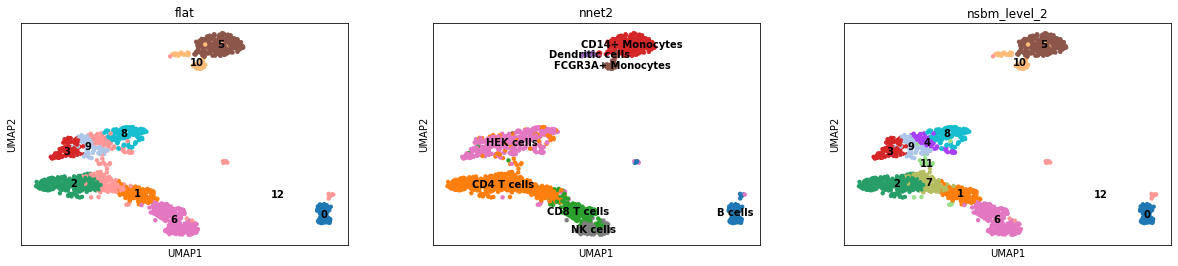

[0.0, 0.024193548387096774, 0.014234875444839857, 0.0, 0.08771929824561403, 0.0, 0.00398406374501992, 0.08737864077669903, 0.0, 0.0273972602739726, 0.015625, 0.10526315789473684, 0.0]


In [84]:
level=str(2)
marginals = adata.uns['nsbm']['cell_affinity'][level] 
adata.obs['max_P'] = -np.log10(np.max(marginals, axis=1))
#adata.obs['max_P'] = np.max(marginals,axis=1)
group_sig=[]
group_names = adata.obs[f'nsbm_level_{level}'].cat.categories
for group in group_names:
    adata0=adata[adata.obs[f'nsbm_level_{level}']==group]
    c=0
    for i in adata0.obs['max_P']:
        if i>0.05:
#        if i>0.95:
            c=c+1
    c=c/(len(adata0.obs['max_P']))
    group_sig.append(c)
cdata=adata
flat=pd.Series()
for i in range(len(group_sig)):
    if group_sig[i]<0.05:
#    if group_sig[i]>0.95:
        a=pd.Series(cdata.obs[f'nsbm_level_{level}'][cdata.obs[f'nsbm_level_{level}']==str(i)], index=cdata.obs[f'nsbm_level_{level}'].index[cdata.obs[f'nsbm_level_{level}']==str(i)])
        flat=pd.Series.append(flat,a, ignore_index=False, verify_integrity=True)
        print(i)
cdata.obs['flat']=flat
sc.pl.umap(cdata, color=['flat','nnet2',f'nsbm_level_{level}'],legend_loc='on data')
print(group_sig)

In [16]:
level=1
entro=scipy.stats.entropy(adata.uns['nsbm']['cell_affinity'][f'{level}'], axis=0)/ np.log(adata.shape[0])
top_entro=[(x,y) for (y,x) in enumerate(entro)]

In [22]:
print( sorted( [(x,i) for (i,x) in enumerate(entro)], reverse=False )[:5] )

[(0.4151677780098972, 15), (0.4679073527501984, 16), (0.4808074057245199, 11), (0.49944253078980116, 17), (0.535699920784978, 3)]


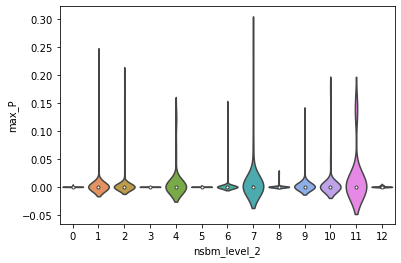

In [85]:
sns.violinplot(x=f'nsbm_level_{level}', y='max_P', data = adata.obs, scale='width')

In [58]:
M=adata.uns['nsbm']['cell_affinity']['1']
adata.obs['max_u'] = 1 - np.max(M, axis=1)
sort_w=adata[adata.obs.max_u<1e-10]
sort_w.n_obs*len(adata.obs.nsbm_level_1.cat.categories)

13906

In [55]:
M=adata.uns['nsbm']['cell_affinity']['2']
adata.obs['max_u'] = 1 - np.max(M, axis=1)
sort_unw=adata[adata.obs.max_u<1e-10]
sort_unw.n_obs*len(adata.obs.nsbm_level_2.cat.categories)

13442

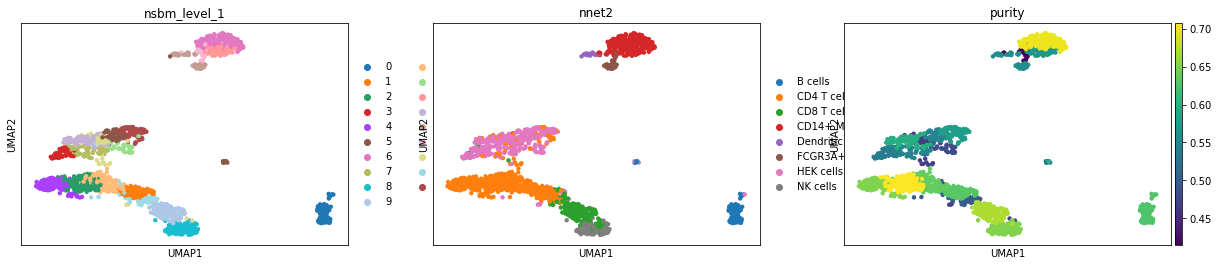

In [78]:
level=1
entro=scipy.stats.entropy(adata.uns['nsbm']['cell_affinity'][f'{level}'], axis=0)/ np.log(adata.shape[0])
purity= []
for i in adata.obs[f'nsbm_level_{level}']:
    purity.append(entro[int(i)])
adata.obs['purity']=purity
sc.pl.umap(adata,color=[f'nsbm_level_{level}','nnet2','purity'])

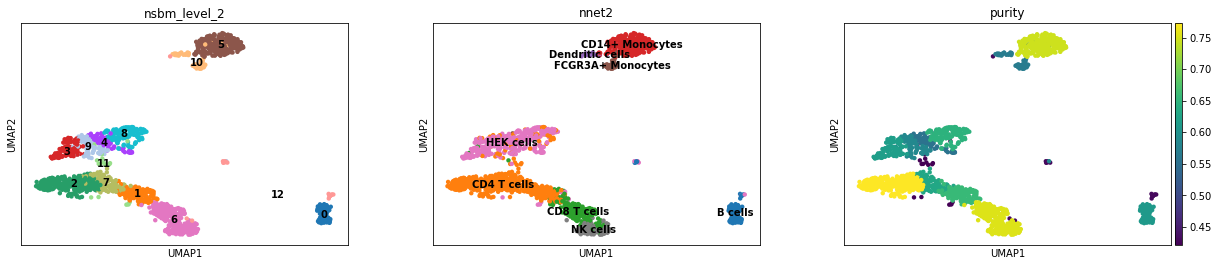

In [86]:
level=2
entro=scipy.stats.entropy(adata.uns['nsbm']['cell_affinity'][f'{level}'], axis=0)/ np.log(adata.shape[0])
purity= []
for i in adata.obs[f'nsbm_level_{level}']:
    purity.append(entro[int(i)])
adata.obs['purity']=purity
sc.pl.umap(adata,color=[f'nsbm_level_{level}','nnet2','purity'],legend_loc='on data')